# Wilson's Morning Wake Up Playlist Generator, Feature Engineering

This notebook is broken down into the following tasks:

* Clean and pre-process the data.
* Standardization and normalization of numerical variables
* Define features for harmonic sequencing
* Create train/test `.csv` files that hold the relevant features and class labels for train/test data points

In the _next_ notebook, Train_Deploy , we will use the features and `.csv` files created in _this_ notebook to train an estimator in a SageMaker notebook instance.

In [10]:
# Import librariess
import pandas as pd
import numpy as np
import os
import pickle

This Wilson Morning Wake Up dataset is summarized in a `.csv` file named `wmw_tracks.csv`, which we can read in using `pandas`. This was created in the Explore notebook.

In [11]:
# Read file
csv_file = 'data/wmw_tracks.csv'
wmw_df = pd.read_csv(csv_file)
wmw_df.head()

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,38,1,Finding It There,Goldmund,0.187,0.00257,1,-37.134,1,0.0427,...,0.0915,0.0374,123.707,audio_features,6CnPCuUcM3A5PMP4gUy0vw,spotify:track:6CnPCuUcM3A5PMP4gUy0vw,https://api.spotify.com/v1/tracks/6CnPCuUcM3A5...,https://api.spotify.com/v1/audio-analysis/6CnP...,220120,5
1,38,2,Light Forms,Rohne,0.671,0.54500,10,-12.848,0,0.0393,...,0.1180,0.2840,133.036,audio_features,6MkUPsz5hYeneo0a9H0VT8,spotify:track:6MkUPsz5hYeneo0a9H0VT8,https://api.spotify.com/v1/tracks/6MkUPsz5hYen...,https://api.spotify.com/v1/audio-analysis/6MkU...,265870,4
2,38,3,C-Side,Khruangbin,0.688,0.77900,11,-10.129,0,0.0579,...,0.3490,0.9380,94.073,audio_features,6GvAM8oyVApQHGMgpBt8yl,spotify:track:6GvAM8oyVApQHGMgpBt8yl,https://api.spotify.com/v1/tracks/6GvAM8oyVApQ...,https://api.spotify.com/v1/audio-analysis/6GvA...,283407,4
3,38,4,Didn't I (Dave Allison Rework),Darondo,0.539,0.70500,0,-6.729,1,0.0527,...,0.1330,0.6850,186.033,audio_features,1owjOeZt1BdYWW6T8fIAEe,spotify:track:1owjOeZt1BdYWW6T8fIAEe,https://api.spotify.com/v1/tracks/1owjOeZt1BdY...,https://api.spotify.com/v1/audio-analysis/1owj...,328000,4
4,38,5,Woman Of The Ghetto - Akshin Alizadeh Remix,Marlena Shaw,0.707,0.57300,7,-8.403,0,0.0276,...,0.0858,0.1890,100.006,audio_features,2h8cQH7zhUWrynZi2MKhhC,spotify:track:2h8cQH7zhUWrynZi2MKhhC,https://api.spotify.com/v1/tracks/2h8cQH7zhUWr...,https://api.spotify.com/v1/audio-analysis/2h8c...,302467,4


In [12]:
# Show duplicated songs - woops!
wmw_df[wmw_df.duplicated(['track_name', 'artist_name'], keep=False)].sort_values('track_name')

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
525,3,15,4AM,Vessels,0.482,0.794,0,-10.800,0,0.0442,...,0.1070,0.0382,150.036,audio_features,4MCL9tV2X5OiwT1oIl9pqK,spotify:track:4MCL9tV2X5OiwT1oIl9pqK,https://api.spotify.com/v1/tracks/4MCL9tV2X5Oi...,https://api.spotify.com/v1/audio-analysis/4MCL...,395229,4
451,8,15,4AM,Vessels,0.482,0.794,0,-10.800,0,0.0442,...,0.1070,0.0382,150.036,audio_features,77HWONgBl3FZbXarvXfRjc,spotify:track:77HWONgBl3FZbXarvXfRjc,https://api.spotify.com/v1/tracks/77HWONgBl3FZ...,https://api.spotify.com/v1/audio-analysis/77HW...,395229,4
192,26,10,Always Like This - Andhim Remix,HVOB,0.793,0.480,1,-12.183,0,0.0829,...,0.4690,0.2480,122.030,audio_features,7qfLlPC8tlohz2QYwGqkJW,spotify:track:7qfLlPC8tlohz2QYwGqkJW,https://api.spotify.com/v1/tracks/7qfLlPC8tloh...,https://api.spotify.com/v1/audio-analysis/7qfL...,359016,4
207,25,10,Always Like This - Andhim Remix,HVOB,0.793,0.480,1,-12.183,0,0.0829,...,0.4690,0.2480,122.030,audio_features,7qfLlPC8tlohz2QYwGqkJW,spotify:track:7qfLlPC8tlohz2QYwGqkJW,https://api.spotify.com/v1/tracks/7qfLlPC8tloh...,https://api.spotify.com/v1/audio-analysis/7qfL...,359016,4
184,26,2,Anchor (feat. Ishmael),Laurence Guy,0.706,0.640,11,-12.578,1,0.0416,...,0.0915,0.5750,121.024,audio_features,2FVgIrE55fd4ktm86pfhFx,spotify:track:2FVgIrE55fd4ktm86pfhFx,https://api.spotify.com/v1/tracks/2FVgIrE55fd4...,https://api.spotify.com/v1/audio-analysis/2FVg...,287666,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,34,6,U,DJ Seinfeld,0.721,0.838,8,-7.579,1,0.0428,...,0.0445,0.4530,125.999,audio_features,2tYctbOGPK2OZ2g2wKipgj,spotify:track:2tYctbOGPK2OZ2g2wKipgj,https://api.spotify.com/v1/tracks/2tYctbOGPK2O...,https://api.spotify.com/v1/audio-analysis/2tYc...,368000,4
339,15,8,Underworld,Edu Imbernon,0.878,0.482,8,-11.166,1,0.0483,...,0.0701,0.2970,123.023,audio_features,2gGeFW6SBAG5K5SNIQ4LW4,spotify:track:2gGeFW6SBAG5K5SNIQ4LW4,https://api.spotify.com/v1/tracks/2gGeFW6SBAG5...,https://api.spotify.com/v1/audio-analysis/2gGe...,425463,4
490,5,11,Underworld,Edu Imbernon,0.862,0.542,8,-10.615,1,0.0449,...,0.1070,0.3230,122.991,audio_features,2T0QyKXxEGsEGkY31deDam,spotify:track:2T0QyKXxEGsEGkY31deDam,https://api.spotify.com/v1/tracks/2T0QyKXxEGsE...,https://api.spotify.com/v1/audio-analysis/2T0Q...,320000,4
183,26,1,Vates,Otto Totland,0.360,0.231,4,-26.701,0,0.0336,...,0.0878,0.2820,104.094,audio_features,5lfBUkuT4mprXGQML18tyq,spotify:track:5lfBUkuT4mprXGQML18tyq,https://api.spotify.com/v1/tracks/5lfBUkuT4mpr...,https://api.spotify.com/v1/audio-analysis/5lfB...,256725,4


In [13]:
wmw_df.columns

Index(['volume', 'position', 'track_name', 'artist_name', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [14]:
# HOLD ON to duplicates
# print("Initial shape:", wmw_df.shape[0], 'tracks')
# wmw_df.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)
# print("New shape:", wmw_df.shape[0], 'tracks')

In [15]:
# Exclude unnecessary columns
exclude_cols = ['track_name', 'artist_name', 'duration_ms', 'track_href', 'uri', 'time_signature', 'id', 'type', 'analysis_url', 'mode','key']

wmw_df.drop(columns=exclude_cols, inplace=True)

In [16]:
# Feature list
feature_list = ['danceability','energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Hold out: 'mode','key','tempo'

# Output list
output_list = ['danceability','energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [17]:
from sklearn.preprocessing import StandardScaler

# Standardize features
standard_scaler = StandardScaler()

standard_scaler.fit(wmw_df[feature_list])

standard_features = standard_scaler.transform(wmw_df[feature_list])

processed_df = pd.DataFrame(standard_features, index=wmw_df.index, columns=wmw_df.columns[2:])

wmw_df = pd.concat([wmw_df[['volume', 'position']],processed_df[feature_list]], axis=1)

wmw_df.head()

,volume,position,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,38,1,-2.434961,-2.688409,-5.475964,-0.284443,2.149991,0.929494,-0.486754,-1.181329,0.224011
1,38,2,0.274338,-0.155380,-0.391172,-0.360369,0.721999,0.642088,-0.287181,-0.137987,0.670798
2,38,3,0.369499,0.937349,0.178108,0.054989,-0.752478,-1.491687,1.452494,2.629027,-1.195227
3,38,4,-0.464562,0.591785,0.889971,-0.061132,-0.844902,-1.442334,-0.174215,1.558607,3.208942
4,38,5,0.475856,-0.024626,0.539483,-0.621642,-0.794102,-0.989452,-0.529681,-0.539923,-0.911082


In [18]:
#TODO- Save StandarScaler for later us
from pickle import dump

# save the scaler
dump(standard_scaler, open('standard_features.pkl', 'wb'))

In [19]:
wmw_df.columns

Index(['volume', 'position', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [20]:
# Prepare labels using shift
training_df = pd.DataFrame()

for i in wmw_df['volume'].unique():
    X_df = wmw_df[wmw_df['volume'] == i]
    y_df = wmw_df[wmw_df['volume'] == i].shift(-1)[output_list]
    X_y_df = pd.concat([X_df, y_df.add_prefix('y_')], axis=1).dropna()
    training_df = training_df.append(X_y_df, ignore_index=True)
    
    # Clean up
    del X_df
    del y_df
    del X_y_df

In [21]:
training_df.head()

,volume,position,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,y_danceability,y_energy,y_loudness,y_speechiness,y_acousticness,y_instrumentalness,y_liveness,y_valence,y_tempo
0,38,1,-2.434961,-2.688409,-5.475964,-0.284443,2.149991,0.929494,-0.486754,-1.181329,0.224011,0.274338,-0.155380,-0.391172,-0.360369,0.721999,0.642088,-0.287181,-0.137987,0.670798
1,38,2,0.274338,-0.155380,-0.391172,-0.360369,0.721999,0.642088,-0.287181,-0.137987,0.670798,0.369499,0.937349,0.178108,0.054989,-0.752478,-1.491687,1.452494,2.629027,-1.195227
2,38,3,0.369499,0.937349,0.178108,0.054989,-0.752478,-1.491687,1.452494,2.629027,-1.195227,-0.464562,0.591785,0.889971,-0.061132,-0.844902,-1.442334,-0.174215,1.558607,3.208942
3,38,4,-0.464562,0.591785,0.889971,-0.061132,-0.844902,-1.442334,-0.174215,1.558607,3.208942,0.475856,-0.024626,0.539483,-0.621642,-0.794102,-0.989452,-0.529681,-0.539923,-0.911082
4,38,5,0.475856,-0.024626,0.539483,-0.621642,-0.794102,-0.989452,-0.529681,-0.539923,-0.911082,0.682972,1.198857,0.100222,-0.056666,0.345253,0.810467,-0.752600,-0.087216,-0.049453


In [22]:
def make_csv(x, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    data = pd.DataFrame(x).dropna()
    data.to_csv(os.path.join(data_dir, filename), index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [23]:
# Can change directory, if you want
data_dir = 'data'

make_csv(wmw_df, filename='wmw.csv', data_dir=data_dir)

Path created: data/wmw.csv


In [24]:
# Can change directory, if you want
data_dir = 'data'

make_csv(training_df, filename='train.csv', data_dir=data_dir)

Path created: data/train.csv


In [211]:
training_df.iloc[:, 2:10].head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,-2.434961,-2.688409,-5.475964,-0.284443,2.149991,0.929494,-0.486754,-1.181329
1,0.274338,-0.155380,-0.391172,-0.360369,0.721999,0.642088,-0.287181,-0.137987
2,0.369499,0.937349,0.178108,0.054989,-0.752478,-1.491687,1.452494,2.629027
3,-0.464562,0.591785,0.889971,-0.061132,-0.844902,-1.442334,-0.174215,1.558607
4,0.475856,-0.024626,0.539483,-0.621642,-0.794102,-0.989452,-0.529681,-0.539923


In [212]:
training_df.iloc[:, 10:].head()

,y_danceability,y_energy,y_loudness,y_speechiness,y_acousticness,y_instrumentalness,y_liveness,y_valence
0,0.274338,-0.155380,-0.391172,-0.360369,0.721999,0.642088,-0.287181,-0.137987
1,0.369499,0.937349,0.178108,0.054989,-0.752478,-1.491687,1.452494,2.629027
2,-0.464562,0.591785,0.889971,-0.061132,-0.844902,-1.442334,-0.174215,1.558607
3,0.475856,-0.024626,0.539483,-0.621642,-0.794102,-0.989452,-0.529681,-0.539923
4,0.682972,1.198857,0.100222,-0.056666,0.345253,0.810467,-0.752600,-0.087216


In [213]:
# Build sequences and targets
def create_playlist_sequences(input_data):
    input_playlists = []
    
    for i in input_data['volume'].unique():
        temp_vol = input_data[input_data['volume'] == i]
        X = temp_vol.iloc[:, 2:10].values
        y = temp_vol.iloc[:, 10:].values
        input_playlists.append((X, y))
        
    return input_playlists

In [214]:
# Gather sequences and targets
processed_data = create_playlist_sequences(training_df)

# Take a look at first input and target
print("X", processed_data[0][0][0])
print("y", processed_data[0][1][0])

X [-2.43496114 -2.68840897 -5.47596419 -0.28444305  2.14999105  0.92949431
 -0.48675387 -1.18132905]
y [ 0.27433807 -0.15537979 -0.39117215 -0.3603687   0.72199948  0.64208789
 -0.28718079 -0.13798717]


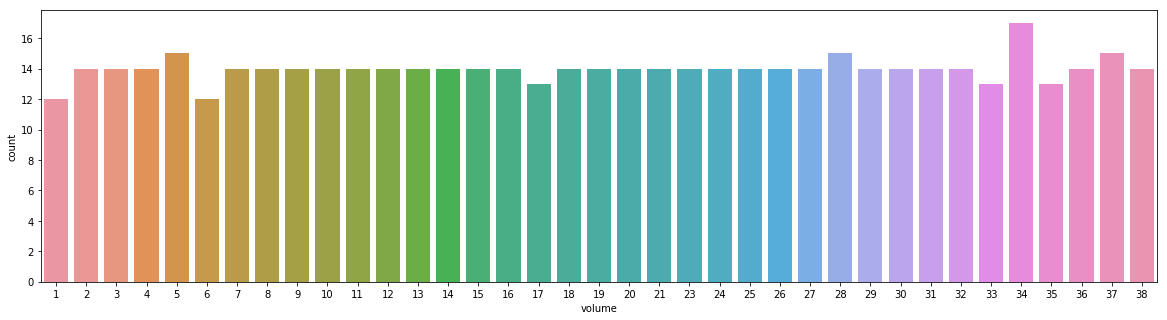

In [168]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

ax = sns.countplot(x="volume", data=training_df)

# training_df.plot.bar(x='volume', rot=0)

In [16]:
from unittest.mock import MagicMock, patch

def _print_success_message():
    print('Tests Passed!')

def test_playlist_sequences(input_playlists):
    
    track_features = [-2.39099487, -2.63509459, -0.27732204,  0.92969533, -0.48983686,-1.15691947,  1.08569029, -1.20454903,  2.09618458, -5.37044178, 0.23380331]
    
    track_features_len = 11
    target_features_len = 8
    
    # check shape and equality of first track
    assert len(input_playlists[0][0][0]) == len(track_features), \
        'Number of features in input_playlist features does not match expected number of ' + str(len(track_features))    
    
    # check shape of input and output arrays
    assert input_playlists[0][0].shape[1]==track_features_len, \
        'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    assert input_playlists[0][1].shape[1]==target_features_len, \
        'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
    #TODO: Add more tests
    
    _print_success_message()

In [17]:
# Test processed sequences
test_playlist_sequences(processed_data)

Tests Passed!
